# Espaço de estados - Parte 1

[Slides da aula](https://marofe.github.io/controle-digital/2024/aula8.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete, tf2zpk, dlti, dstep
from control.matlab import *
from scipy import signal

### Questão 1

Nessa atividade, o objetivo é explorar os recursos computacionais do **Matlab** para obter modelos em espaço de estados equivalentes em tempo discreto.  

Para isso, considere o modelo em espaço de estados em tempo contínuo a seguir:  

$$  
\dot{x}(t) =  
\begin{bmatrix}  
1 & 1 \\  
0 & 2  
\end{bmatrix}  
x(t) +  
\begin{bmatrix}  
1 \\  
3  
\end{bmatrix}  
u(t)  
$$  

O modelo em espaço de estados equivalente em tempo discreto é dado por:  

$$  
x_{k+1} = A_d x_k + B_d u_k  
$$  

em que:  

$$  
A_d = e^{A T_s}  
\tag{1}  
$$  

$$  
B_d = \int_0^{T_s} e^{A \eta} d\eta B  
\tag{2}  
$$  

no qual $T_s$ é o tempo de amostragem. No exemplo acima, a matriz $A$ é não-singular, portanto, existe $A^{-1}$ e pode-se obter $B_d$ na forma:  

$$  
B_d = A^{-1}(e^{A T_s} - I)B  
$$  

O modelo equivalente em tempo discreto pode ser obtido aplicando as equações acima ou através da função do **Matlab** `c2d`.  

O código **Matlab** a seguir obtém o modelo discretizado equivalente, para $T_s = 0.1s$, usando as equações acima e também com a função `c2d`:  

```matlab
1 close all
2 clear all
3 clc
4 %%
5 A=[1 1;...
6 0 2];
7 B=[1;...
8 3];
9 %%
10 Ts=0.1;
11 %%
12 Ad=expm(A*Ts)
13 Bd=A\(Ad−eye(size(Ad)))*B
14 %%
15 [Ad2,Bd2]=c2d(A,B,Ts)
```


Usando a mesma lógica, obtenha o modelo em tempo discreto, com $T_s = 0.5s$, para o sistema:  

$$  
\dot{x}(t) =  
\begin{bmatrix}  
3 & 0 & 0 \\  
5 & 4 & 0 \\  
1 & 2 & 3  
\end{bmatrix}  
x(t) +  
\begin{bmatrix}  
0 \\  
2 \\  
5  
\end{bmatrix}  
u(t)  
$$  

Compare os resultados das equações de discretização apresentadas acima com os resultados da função `c2d`.  


In [2]:
# Implementações
import numpy as np
from scipy.linalg import expm
from scipy.signal import cont2discrete

# Definir a matriz A
A = np.array([[3, 0, 0],
              [5, 4, 0],
              [1, 2, 3]])

# Definir a matriz B
B = np.array([[0],
              [2],
              [5]])

# Definir o tempo de amostragem Ts
Ts = 0.5

# Calcular Ad usando a fórmula Ad = expm(A*Ts)
Ad = expm(A * Ts)

# Calcular Bd usando a fórmula Bd = A^{-1}*(Ad - I)*B
A_inv = np.linalg.inv(A)
Bd = A_inv @ (Ad - np.eye(A.shape[0])) @ B

# Definir as matrizes C e D para cont2discrete (necessárias para a função)
C = np.zeros((A.shape[0], A.shape[0]))
D = np.zeros((A.shape[0], B.shape[1]))

# Usar a função cont2discrete para obter Ad2 e Bd2
system = (A, B, C, D)
Ad2, Bd2, _, _, _ = cont2discrete(system, Ts)


In [3]:
# Prints e Plots
print("Ad calculado usando expm:")
print(Ad)

print("\nBd calculado usando A^{-1}*(Ad - I)*B:")
print(Bd)

print("\nAd2 e Bd2 calculados usando cont2discrete:")
print("Ad2:")
print(Ad2)
print("\nBd2:")
print(Bd2)

# Comparar os resultados
print("\nDiferença entre Ad e Ad2:")
print(Ad - Ad2)

print("\nDiferença entre Bd e Bd2:")
print(Bd - Bd2)


Ad calculado usando expm:
[[ 4.48168907  0.          0.        ]
 [14.53683514  7.3890561   0.        ]
 [ 8.90606947  5.81473406  4.48168907]]

Bd calculado usando A^{-1}*(Ad - I)*B:
[[0.        ]
 [3.19452805]
 [7.54961912]]

Ad2 e Bd2 calculados usando cont2discrete:
Ad2:
[[4.48168907e+00 0.00000000e+00 0.00000000e+00]
 [1.45368351e+01 7.38905610e+00 1.96858824e-16]
 [8.90606947e+00 5.81473406e+00 4.48168907e+00]]

Bd2:
[[0.        ]
 [3.19452805]
 [7.54961912]]

Diferença entre Ad e Ad2:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.96858824e-16]
 [-1.77635684e-15 -8.88178420e-16 -8.88178420e-16]]

Diferença entre Bd e Bd2:
[[ 0.00000000e+00]
 [-4.44089210e-16]
 [-3.55271368e-15]]


### Questão 2

Nessa atividade, o objetivo é explorar os recursos computacionais do **Matlab** para avaliar a estabilidade assintótica de modelos em espaço de estados em tempo discreto.  

Para isso, considere o seguinte sistema como exemplo:  

$$  
x_{k+1} =  
\begin{bmatrix}  
1 & -2 \\  
2 & 1  
\end{bmatrix}  
x_k  
\quad \text{com a matriz} \quad A_d =  
\begin{bmatrix}  
1 & -2 \\  
2 & 1  
\end{bmatrix}  
$$  

Um modelo em espaço de estados em tempo discreto é assintoticamente estável se os autovalores da matriz de dinâmica $A_d$ estiverem dentro do círculo unitário:  

$$  
|\lambda(A_d)| < 1.  
$$  

Outra forma de avaliar a estabilidade do sistema é através da equação de Lyapunov. Se existir $P \in \mathbb{R}^{n \times n}$ tal que:  

$$  
A_d^\top P A_d - P = -Q, \quad Q > 0, \quad P > 0  
$$  

então o sistema $x_{k+1} = A_d x_k$ é assintoticamente estável. A matriz $Q > 0$ é arbitrária.  

No **Matlab**, pode-se utilizar o comando `eig` para obter os autovalores de $A_d$ e a função `dlyap` para encontrar a solução da equação de Lyapunov.  

---

O código **Matlab** a seguir avalia a estabilidade do sistema:  

```matlab
1 close all
2 clear all
3 clc
4 %%
5 Ad=[1 −2;...
6 2 1];
7 Bd=[1;...
8 2];
9 %%
10 eig(Ad) %obtem autovalores de Ad
11 if any(abs(eig(Ad))≥1) %verifica se existe algum autovalor maior que 1
12 disp('Sistema nao e assintoticamente estavel!')
13 else
14 disp('Sistema e assintoticamente estavel!')
15 end
16 %%
17 Q=eye(size(Ad))
18 P=dlyap(Ad,Q) %obtem solucao da eq. de lyapunov
19 if any(eig(P)≤0) %verifica se P>0
20 disp('Sistema nao e assintoticamente estavel!')
21 else
22 disp('Sistema e assintoticamente estavel!')
23 end
```

---

Usando a mesma lógica, avalie a estabilidade assintótica do sistema:  

$$  
x_{k+1} =  
\begin{bmatrix}  
0.75 & -0.25 & 4 \\  
2.25 & -0.75 & 0 \\  
-0.375 & 0.125 & 3.5  
\end{bmatrix}  
x_k  
\quad \text{com a matriz} \quad A_d =  
\begin{bmatrix}  
0.75 & -0.25 & 4 \\  
2.25 & -0.75 & 0 \\  
-0.375 & 0.125 & 3.5  
\end{bmatrix}  
$$  


In [4]:
# Implementações
import numpy as np
from scipy.linalg import eigvals, solve_discrete_lyapunov

# Definir a matriz Ad
Ad = np.array([[0.75, -0.25, 4],
               [2.25, -0.75, 0],
               [-0.375, 0.125, 3.5]])

# Calcular os autovalores de Ad
eigenvalues = eigvals(Ad)

# Verificar se algum autovalor tem módulo maior ou igual a 1
is_stable_eigen = np.all(np.abs(eigenvalues) < 1)

# Definir a matriz Q positiva definida (identidade)
Q = np.eye(Ad.shape[0])

# Resolver a equação de Lyapunov discreta: Ad^T * P * Ad - P = -Q
P = solve_discrete_lyapunov(Ad.T, Q)

# Verificar se P é positiva definida
eig_P = np.linalg.eigvals(P)
is_positive_definite_P = np.all(eig_P > 0)


In [5]:
# Prints e Plots
print("Autovalores de Ad:")
print(eigenvalues)

if is_stable_eigen:
    print("\nSistema é assintoticamente estável (critério dos autovalores).")
else:
    print("\nSistema não é assintoticamente estável (critério dos autovalores).")

print("\nMatriz P obtida da equação de Lyapunov:")
print(P)

if is_positive_definite_P:
    print("\nSistema é assintoticamente estável (critério de Lyapunov).")
else:
    print("\nSistema não é assintoticamente estável (critério de Lyapunov).")


Autovalores de Ad:
[-1.22124533e-15+0.j  5.00000000e-01+0.j  3.00000000e+00+0.j]

Sistema não é assintoticamente estável (critério dos autovalores).

Matriz P obtida da equação de Lyapunov:
[[ 23.1015625   -7.3671875  -60.3125    ]
 [ -7.3671875    3.45572917  20.10416667]
 [-60.3125      20.10416667 117.16666667]]

Sistema não é assintoticamente estável (critério de Lyapunov).


### Questão 3

Nessa atividade, o objetivo é explorar os recursos computacionais do **Matlab** para simular modelos em espaço de estados em tempo discreto.  

Considere o sistema em tempo contínuo dado por:  

$$  
\dot{x}(t) =  
\begin{bmatrix}  
-2 & 1 \\  
0 & -1  
\end{bmatrix}  
x(t) +  
\begin{bmatrix}  
1 \\  
1  
\end{bmatrix}  
u(t)  
$$  

---

O seguinte código em **Matlab** simula esse sistema para $T_s = 0.2s$ com entrada degrau unitário e compara com o sistema em tempo contínuo (amostragem bem pequena).  

```matlab
1 close all
2 clear all
3 clc
4 %%
5 A=[−2 1;...
6 0 −1];
7 B=[1;...
8 1];
9 %%
10 Ts=0.2;
11 T=5;
12 td=0:Ts:T;
13 dt=0.001;
14 t=0:dt:T;
15 %%
16 [Ac,Bc]=c2d(A,B,dt); %modelo tempo continuo (aproximacao)
17 [Ad,Bd]=c2d(A,B,Ts); %modelo em tempo discreto
18 %%
19 Nd=numel(td);
20 Nc=numel(t);
21 n=size(Ad,1);
22 x=zeros(n,Nc);
23 xd=zeros(n,Nd);
24 u=ones(Nd,1);
25 xd(:,1)=[10;−5];
26 x(:,1)=xd(:,1);
27 %%
28 Nr=Ts/dt;
29 kd=1;
30 for k=1:Nc−1
31 %% simula sistema em tempo continuo
32 x(:,k+1)=Ac*x(:,k)+Bc*u(kd);
33 %% simula sistema em tempo discreto
34 if mod(k,Nr)==0 && kd≤numel(td)
35 xd(:,kd+1)=Ad*xd(:,kd)+Bd*u(kd);
36 kd=kd+1;
37 end
38 end
39 %%
40 figure
41 subplot(2,1,1)
42 plot(t,x(1,:),'LineWidth',1.5)
43 hold on
44 stairs(td,xd(1,:),'LineWidth',1.5)
45 xlabel('Tempo')
46 legend('Continuo','Discreto')
47 title('Estado 1')
48 subplot(2,1,2)
49 plot(t,x(2,:),'LineWidth',1.5)
50 hold on
51 stairs(td,xd(2,:),'LineWidth',1.5)
52 xlabel('Tempo')
53 legend('Continuo','Discreto')
54 title('Estado 2')
```
---

Seguindo a mesma lógica, simule o sistema a seguir com entrada degrau unitário e $T_s = 0.3s$. Considere $x(0) = [10 \quad 15 \quad -5]^\top$.  

$$  
\dot{x}(t) =  
\begin{bmatrix}  
-2 & 1 & 0 \\  
0 & -1 & 0 \\  
0 & 0 & -3  
\end{bmatrix}  
x(t) +  
\begin{bmatrix}  
1 \\  
1 \\  
1  
\end{bmatrix}  
u(t)  
$$  


In [6]:
# Implementações
import numpy as np
from scipy.signal import cont2discrete
import matplotlib.pyplot as plt

# Definir as matrizes A e B
A = np.array([[-2, 1, 0],
              [0, -1, 0],
              [0, 0, -3]])

B = np.array([[1],
              [1],
              [1]])

# Definir os tempos de amostragem e simulação
Ts = 0.3      # Tempo de amostragem do sistema discreto
T = 5         # Tempo total de simulação
dt = 0.001    # Passo de tempo para simulação contínua (aproximação)

td = np.arange(0, T + Ts, Ts)  # Instantes de tempo discretos
t = np.arange(0, T + dt, dt)   # Instantes de tempo contínuos

# Discretizar o sistema contínuo para simulação contínua (aproximação)
# usando um passo de tempo muito pequeno dt
Ac, Bc, _, _, _ = cont2discrete((A, B, np.eye(A.shape[0]), np.zeros((A.shape[0], B.shape[1]))), dt)
Ac = Ac
Bc = Bc

# Discretizar o sistema com tempo de amostragem Ts
Ad, Bd, _, _, _ = cont2discrete((A, B, np.eye(A.shape[0]), np.zeros((A.shape[0], B.shape[1]))), Ts)

# Inicializar as variáveis
Nd = len(td)    # Número de pontos no tempo discreto
Nc = len(t)     # Número de pontos no tempo contínuo
n = A.shape[0]  # Número de estados

x = np.zeros((n, Nc))   # Trajetória de estados contínua
xd = np.zeros((n, Nd))  # Trajetória de estados discreta

u = np.ones(Nd)         # Entrada (degrau unitário)

# Condição inicial
xd[:, 0] = np.array([10, 15, -5])  # Estado inicial para o sistema discreto
x[:, 0] = xd[:, 0]                 # Estado inicial para o sistema contínuo

# Simulação
Nr = int(Ts / dt)  # Razão entre o tempo de amostragem e dt
kd = 0             # Índice de tempo discreto

for k in range(Nc - 1):
    # Simular o sistema contínuo
    x[:, k + 1] = Ac @ x[:, k] + Bc[:, 0] * u[kd]
    
    # Simular o sistema discreto nos instantes apropriados
    if (k + 1) % Nr == 0 and kd + 1 < Nd:
        xd[:, kd + 1] = Ad @ xd[:, kd] + Bd[:, 0] * u[kd]
        kd += 1


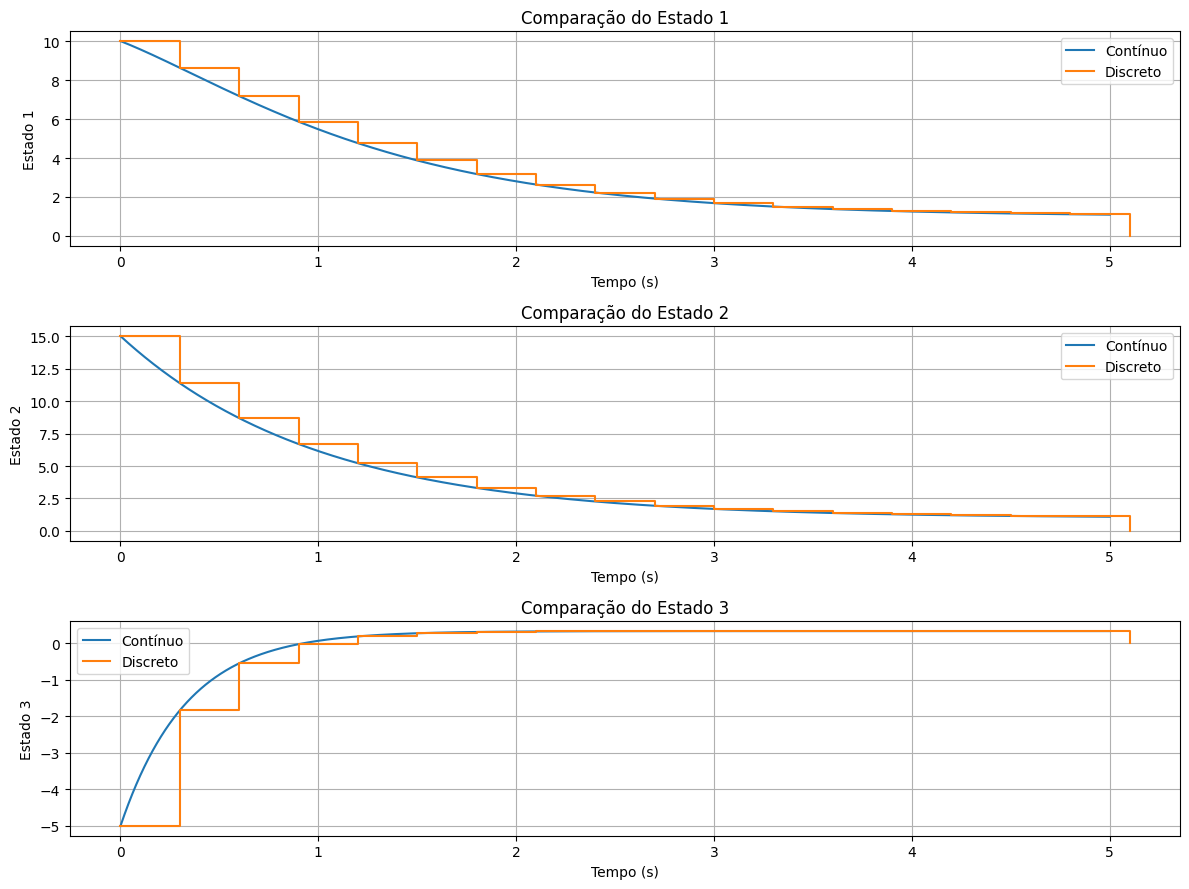

In [7]:
# Prints e Plots

# Plotar os resultados
plt.figure(figsize=(12, 9))

# Estado 1
plt.subplot(3, 1, 1)
plt.plot(t, x[0, :], label='Contínuo', linewidth=1.5)
plt.step(td, xd[0, :], where='post', label='Discreto', linewidth=1.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Estado 1')
plt.title('Comparação do Estado 1')
plt.legend()
plt.grid(True)

# Estado 2
plt.subplot(3, 1, 2)
plt.plot(t, x[1, :], label='Contínuo', linewidth=1.5)
plt.step(td, xd[1, :], where='post', label='Discreto', linewidth=1.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Estado 2')
plt.title('Comparação do Estado 2')
plt.legend()
plt.grid(True)

# Estado 3
plt.subplot(3, 1, 3)
plt.plot(t, x[2, :], label='Contínuo', linewidth=1.5)
plt.step(td, xd[2, :], where='post', label='Discreto', linewidth=1.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Estado 3')
plt.title('Comparação do Estado 3')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Questão 4

Nessa atividade, o objetivo é explorar os recursos simbólicos do **Matlab** para obter modelos linearizados para plantas não-lineares em tempo discreto.  

Nesse exemplo, será utilizado o modelo de um pêndulo invertido conforme ilustrado na Figura 1. As EDO que descrevem o comportamento dessa planta são dadas a seguir:  

$$  
(M + m) \ddot{x} - ml \ddot{\theta} \cos(\theta) + ml \dot{\theta}^2 \sin(\theta) = F,  
\tag{3}  
$$  

$$  
l \ddot{\theta} - \ddot{x} \cos(\theta) - g \sin(\theta) = 0,  
\tag{4}  
$$  

em que o vetor de estados é dado por:  

$$  
x =  
\begin{bmatrix}  
x \\  
\dot{x} \\  
\theta \\  
\dot{\theta}  
\end{bmatrix},  
$$  

---

onde:  
- $x \rightarrow$ posição  
- $\dot{x} \rightarrow$ velocidade  
- $\theta \rightarrow$ posição angular  
- $\dot{\theta} \rightarrow$ velocidade angular  

E o sinal de entrada é a força que atua na plataforma móvel:  

$$  
u = F.  
$$  

Suponha que estejam disponíveis medições da posição $x$ e da posição angular $\theta$. Assim, a equação de saída desse sistema é dada por:  

$$  
y =  
\begin{bmatrix}  
1 & 0 & 0 & 0 \\  
0 & 0 & 1 & 0  
\end{bmatrix}  
x  
$$  

---

Adotando:  

$$  
x_0 =  
\begin{bmatrix}  
0 \\  
0 \\  
0 \\  
0  
\end{bmatrix},  
\quad u_0 = 0,  
$$  

como ponto de operação do sistema (posição vertical com velocidade zero), busca-se um modelo linearizado na forma:  

$$  
\dot{x} = A(x_0, u_0) x + B(x_0, u_0) u,  
$$  

válido para regiões próximas do ponto $(x_0, u_0)$.  

O código **Matlab** a seguir obtém as matrizes $A(x_0, u_0)$ e $B(x_0, u_0)$ do modelo linearizado para esse sistema.  

```matlab
1 close all
2 clear all
3 clc
4 %%
5 syms m M l F g
6 syms th th d th dd
7 syms x x d x dd
8
9 eq1=(M+m)*x dd−m*l*th dd*cos(th)+m*l*th dˆ2*sin(th)−F;
10 eq2=l*th dd−x dd*cos(th)−g*sin(th);
11 u=F;
12 S=solve(eq1==0, eq2==0, x dd, th dd)
13 %%
14 x vet=[x;x d;th;th d];
15 x vet dot=[x d; S.x dd; th d; S.th dd];
16
17 A=simplify(jacobian(x vet dot,x vet))
18 B=simplify(jacobian(x vet dot,u))
19
20 %% ponto de operacao
21 x=0;
22 x d=0;
23 th=0;
24 th d=0;
25 u=0;
26 A0=simplify(subs(A))
27 B0=simplify(subs(B))
28 %%
29 M=1;
30 m=0.1;
31 l=0.4;
32 g=9.81;
33 A0=double(simplify(subs(A)))
34 B0=double(simplify(subs(B)))
```

Após obter o modelo linearizado, pode-se utilizar o comando `c2d` para obter o equivalente em tempo discreto.  

---

Usando a lógica do código acima, obtenha as matrizes do modelo linearizado para o pêndulo invertido em tempo discreto com $T_s = 0.1s$ nos seguintes pontos de operação:  

$$  
x_0 =  
\begin{bmatrix}  
-1 \\  
0 \\  
\pi \\  
0  
\end{bmatrix},  
\quad u_0 = 0  
$$  

e  

$$  
x_0 =  
\begin{bmatrix}  
0 \\  
0 \\  
0 \\  
0  
\end{bmatrix},  
\quad u_0 = 0  
$$  

---

Em seguida, avalie a estabilidade assintótica do modelo linearizado, usando a equação de Lyapunov, nos dois pontos de operação.  

Considere:  

$$  
\begin{aligned}  
M &= 1 \\  
m &= 0.1 \\  
l &= 0.4 \\  
g &= 9.81  
\end{aligned}  
$$  

O sistema linearizado é assintoticamente estável nos dois pontos de operação?  


In [8]:
# Implementações
import sympy as sp
import numpy as np
from scipy.signal import cont2discrete
from scipy.linalg import solve_discrete_lyapunov, eigvals
import warnings

# Definir as variáveis simbólicas
m, M, l, F, g = sp.symbols('m M l F g')
th, th_d, th_dd = sp.symbols('th th_d th_dd')
x, x_d, x_dd = sp.symbols('x x_d x_dd')

# Equações do sistema
eq1 = (M + m)*x_dd - m*l*th_dd*sp.cos(th) + m*l*th_d**2*sp.sin(th) - F
eq2 = l*th_dd - x_dd*sp.cos(th) - g*sp.sin(th)

# Sinal de entrada
u = F

# Resolver as equações para x_dd e th_dd
sol = sp.solve([eq1, eq2], (x_dd, th_dd), simplify=False, rational=False)

# Vetor de estados e suas derivadas
x_vec = sp.Matrix([x, x_d, th, th_d])
x_vec_dot = sp.Matrix([x_d, sol[x_dd], th_d, sol[th_dd]])

# Calcular as Jacobianas A e B
A = x_vec_dot.jacobian(x_vec)
B = x_vec_dot.jacobian([u])

# Pontos de operação
# Primeiro ponto de operação
x0_1 = {x: -1, x_d: 0, th: sp.pi, th_d: 0, u: 0}
# Segundo ponto de operação
x0_2 = {x: 0, x_d: 0, th: 0, th_d: 0, u: 0}

# Valores numéricos dos parâmetros
param_values = {M: 1, m: 0.1, l: 0.4, g: 9.81}

# Substituir os valores nos pontos de operação e avaliar A e B numericamente
A0_1 = A.subs({**x0_1, **param_values})
B0_1 = B.subs({**x0_1, **param_values})
A0_1 = np.array(A0_1.evalf(), dtype=np.float64)
B0_1 = np.array(B0_1.evalf(), dtype=np.float64)

A0_2 = A.subs({**x0_2, **param_values})
B0_2 = B.subs({**x0_2, **param_values})
A0_2 = np.array(A0_2.evalf(), dtype=np.float64)
B0_2 = np.array(B0_2.evalf(), dtype=np.float64)

# Discretizar os sistemas com Ts = 0.1s
Ts = 0.1
Ad1, Bd1, _, _, _ = cont2discrete((A0_1, B0_1, np.eye(4), np.zeros((4,1))), Ts)
Ad1 = Ad1
Bd1 = Bd1

Ad2, Bd2, _, _, _ = cont2discrete((A0_2, B0_2, np.eye(4), np.zeros((4,1))), Ts)
Ad2 = Ad2
Bd2 = Bd2

# Avaliar a estabilidade assintótica usando a equação de Lyapunov
Q = np.eye(4)

# Para o primeiro ponto de operação
eig_Ad1 = eigvals(Ad1)
stable1 = np.all(np.abs(eig_Ad1) < 1)

if stable1:
    try:
        P1 = solve_discrete_lyapunov(Ad1.T, Q)
        eig_P1 = eigvals(P1)
        positive_definite_P1 = np.all(eig_P1 > 0)
    except np.linalg.LinAlgError:
        P1 = None
        positive_definite_P1 = False
else:
    P1 = None
    positive_definite_P1 = False

# Para o segundo ponto de operação
eig_Ad2 = eigvals(Ad2)
stable2 = np.all(np.abs(eig_Ad2) < 1)

if stable2:
    try:
        P2 = solve_discrete_lyapunov(Ad2.T, Q)
        eig_P2 = eigvals(P2)
        positive_definite_P2 = np.all(eig_P2 > 0)
    except np.linalg.LinAlgError:
        P2 = None
        positive_definite_P2 = False
else:
    P2 = None
    positive_definite_P2 = False


In [9]:
# Prints e Plots

# Primeiro ponto de operação
print("Primeiro Ponto de Operação: x0 = [-1, 0, pi, 0], u0 = 0")
print("\nMatriz A contínua no primeiro ponto de operação:")
print(A0_1)

print("\nMatriz B contínua no primeiro ponto de operação:")
print(B0_1)

print("\nMatriz A discreta no primeiro ponto de operação:")
print(Ad1)

print("\nMatriz B discreta no primeiro ponto de operação:")
print(Bd1)

# Autovalores de Ad1
print("\nAutovalores de Ad1:")
print(eig_Ad1)

print("\nO sistema no primeiro ponto de operação é assintoticamente estável?")
print("Sim" if stable1 else "Não")

if stable1 and P1 is not None:
    print("\nMatriz P1 obtida da equação de Lyapunov:")
    print(P1)
    print("\nA matriz P1 é definida positiva?")
    print("Sim" if positive_definite_P1 else "Não")
else:
    print("\nNão é possível resolver a equação de Lyapunov para o primeiro ponto de operação devido à instabilidade do sistema.")

print("\n" + "-"*50)

# Segundo ponto de operação
print("Segundo Ponto de Operação: x0 = [0, 0, 0, 0], u0 = 0")
print("\nMatriz A contínua no segundo ponto de operação:")
print(A0_2)

print("\nMatriz B contínua no segundo ponto de operação:")
print(B0_2)

print("\nMatriz A discreta no segundo ponto de operação:")
print(Ad2)

print("\nMatriz B discreta no segundo ponto de operação:")
print(Bd2)

# Autovalores de Ad2
print("\nAutovalores de Ad2:")
print(eig_Ad2)

print("\nO sistema no segundo ponto de operação é assintoticamente estável?")
print("Sim" if stable2 else "Não")

if stable2 and P2 is not None:
    print("\nMatriz P2 obtida da equação de Lyapunov:")
    print(P2)
    print("\nA matriz P2 é definida positiva?")
    print("Sim" if positive_definite_P2 else "Não")
else:
    print("\nNão é possível resolver a equação de Lyapunov para o segundo ponto de operação devido à instabilidade do sistema.")


Primeiro Ponto de Operação: x0 = [-1, 0, pi, 0], u0 = 0

Matriz A contínua no primeiro ponto de operação:
[[  0.       1.       0.       0.    ]
 [  0.       0.       0.981    0.    ]
 [  0.       0.       0.       1.    ]
 [  0.       0.     -26.9775   0.    ]]

Matriz B contínua no primeiro ponto de operação:
[[ 0. ]
 [ 1. ]
 [ 0. ]
 [-2.5]]

Matriz A discreta no primeiro ponto de operação:
[[ 1.00000000e+00  1.00000000e-01  4.79571631e-03  1.61308702e-04]
 [ 0.00000000e+00  1.00000000e+00  9.37482945e-02  4.79571631e-03]
 [ 0.00000000e+00  0.00000000e+00  8.68117801e-01  9.55640107e-02]
 [ 0.00000000e+00  0.00000000e+00 -2.57807810e+00  8.68117801e-01]]

Matriz B discreta no primeiro ponto de operação:
[[ 0.00498987]
 [ 0.09959673]
 [-0.0122215 ]
 [-0.23891003]]

Autovalores de Ad1:
[1.       +0.j         1.       +0.j         0.8681178+0.49635822j
 0.8681178-0.49635822j]

O sistema no primeiro ponto de operação é assintoticamente estável?
Não

Não é possível resolver a equação de L

### Questão 5

Usando o modelo da **atividade 4** do pêndulo invertido, faça a sintonia de um controlador do tipo **PID** para controlar o pêndulo invertido na posição vertical com $\theta = 0$.  

Use o código de exemplo disponível no **e-disciplina** (arquivo `controle-pendulo-invertido.zip`).  

No arquivo ZIP haverá **4 scripts**:
- Um para o controle,
- Outro para o modelo do sistema,  
- Duas funções auxiliares para gerar uma animação do pêndulo invertido.  

---

Lembre-se de deixar os quatro arquivos na mesma pasta para o **Matlab**.  

---

Após obter sua **melhor sintonia** do controle PID, compare com o desempenho do controle **LQR** (descomente a linha 84).  

---

Explique com suas palavras quais diferenças podem ser observadas entre os dois tipos de controladores.  


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.linalg import solve_continuous_are
from numpy.linalg import inv

# Parâmetros do pêndulo invertido
M = 0.5  # Massa do carrinho (kg)
m = 0.2  # Massa do pêndulo (kg)
b = 0.1  # Coeficiente de fricção do carrinho (N/m/s)
l = 0.3  # Comprimento até o centro de massa do pêndulo (m)
I = 0.006  # Momento de inércia do pêndulo (kg.m^2)
g = 9.8  # Aceleração gravitacional (m/s^2)

# Estado inicial [posição do carrinho, velocidade do carrinho, ângulo, velocidade angular]
x0 = [0.0, 0.0, np.pi, 0.0]

# Parâmetros do controlador PID
Kp = 100
Ki = 1
Kd = 20

# Definição da equação do sistema (modelo)
def modelo_pendulo(x, t, u):
    Sx = np.sin(x[2])
    Cx = np.cos(x[2])
    D = m * l * l * (M + m * (1 - Cx ** 2))

    dx1 = x[1]
    dx2 = (1 / D) * (-m ** 2 * l ** 2 * g * Cx * Sx + m * l ** 2 * (m * l * x[3] ** 2 * Sx - b * x[1])) + m * l * l * (1 / D) * u
    dx3 = x[3]
    dx4 = (1 / D) * ((M + m) * m * g * l * Sx - m * l * Cx * (m * l * x[3] ** 2 * Sx - b * x[1])) - m * l * Cx * (1 / D) * u

    return [dx1, dx2, dx3, dx4]

# Função que simula o controlador PID
def controlador_pid(x, setpoint, prev_error, integral, dt):
    error = setpoint - x[2]  # Erro em relação ao ângulo
    integral += error * dt  # Parte integral
    derivative = (error - prev_error) / dt  # Parte derivativa
    u = Kp * error + Ki * integral + Kd * derivative  # Controlador PID
    return u, error, integral

# Função que simula o controlador LQR
def controlador_lqr(x, K):
    u = -np.dot(K, x)  # Controle LQR é dado por -K*x
    return u

# Matriz de estado A e matriz de entrada B para o modelo linearizado do pêndulo invertido
A = np.array([[0, 1, 0, 0],
              [0, -(I + m * l ** 2) * b / (I * (M + m) + M * m * l ** 2), (m ** 2 * g * l ** 2) / (I * (M + m) + M * m * l ** 2), 0],
              [0, 0, 0, 1],
              [0, -(m * l * b) / (I * (M + m) + M * m * l ** 2), m * g * l * (M + m) / (I * (M + m) + M * m * l ** 2), 0]])

B = np.array([[0], [(I + m * l ** 2) / (I * (M + m) + M * m * l ** 2)], [0], [m * l / (I * (M + m) + M * m * l ** 2)]])

# Definição das matrizes Q e R para o controle LQR
Q = np.diag([10, 1, 10, 1])  # Penaliza o estado (pesos maiores no ângulo e posição)
R = np.array([[0.01]])  # Penaliza o controle

# Solução da equação de Riccati para encontrar a matriz de ganho K
P = solve_continuous_are(A, B, Q, R)
K_lqr = np.dot(inv(R), np.dot(B.T, P))

# Parâmetros da simulação
dt = 0.01  # Intervalo de tempo
t_final = 10  # Tempo final de simulação
t = np.arange(0, t_final, dt)

# Variáveis de controle PID
integral = 0.0
prev_error = 0.0
setpoint = 0.0  # O objetivo é manter o pêndulo vertical (θ = 0)

# Inicialização dos resultados para PID e LQR
x_pid = np.zeros((len(t), 4))  # Estado do sistema [posição, velocidade, ângulo, velocidade angular] com PID
x_lqr = np.zeros((len(t), 4))  # Estado do sistema [posição, velocidade, ângulo, velocidade angular] com LQR
x_pid[0, :] = x0
x_lqr[0, :] = x0
u_pid = np.zeros(len(t))  # Controle aplicado PID
u_lqr = np.zeros(len(t))  # Controle aplicado LQR

# Simulação
for i in range(1, len(t)):
    # Controlador PID
    u_pid[i], prev_error, integral = controlador_pid(x_pid[i-1], setpoint, prev_error, integral, dt)
    x_pid[i, :] = odeint(modelo_pendulo, x_pid[i-1, :], [t[i-1], t[i]], args=(u_pid[i],))[1]
    
    # Controlador LQR
    u_lqr[i] = controlador_lqr(x_lqr[i-1], K_lqr)
    x_lqr[i, :] = odeint(modelo_pendulo, x_lqr[i-1, :], [t[i-1], t[i]], args=(u_lqr[i],))[1]


/home/gian/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


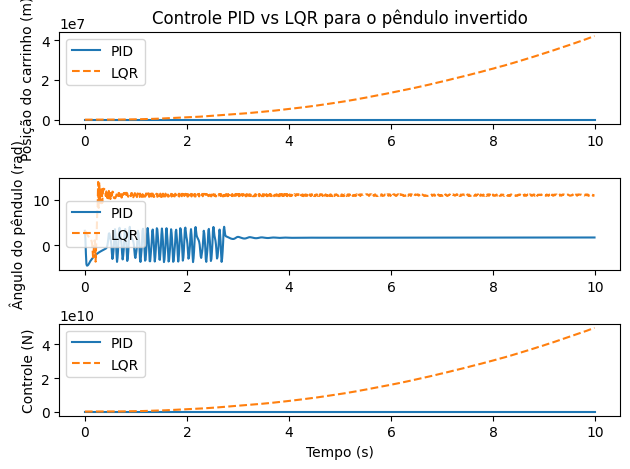

Posição final do carrinho (PID): -4374.2943631569515
Ângulo final do pêndulo (PID): 1.6710818797721947
Posição final do carrinho (LQR): 42066651.392274514
Ângulo final do pêndulo (LQR): 10.968871198964797


In [11]:
# Gráficos de comparação
plt.figure()

# Posição do carrinho ao longo do tempo (PID vs LQR)
plt.subplot(3, 1, 1)
plt.plot(t, x_pid[:, 0], label="PID")
plt.plot(t, x_lqr[:, 0], label="LQR", linestyle='dashed')
plt.title('Controle PID vs LQR para o pêndulo invertido')
plt.ylabel('Posição do carrinho (m)')
plt.legend()

# Ângulo do pêndulo ao longo do tempo (PID vs LQR)
plt.subplot(3, 1, 2)
plt.plot(t, x_pid[:, 2], label="PID")
plt.plot(t, x_lqr[:, 2], label="LQR", linestyle='dashed')
plt.ylabel('Ângulo do pêndulo (rad)')
plt.legend()

# Controle aplicado ao sistema ao longo do tempo (PID vs LQR)
plt.subplot(3, 1, 3)
plt.plot(t, u_pid, label="PID")
plt.plot(t, u_lqr, label="LQR", linestyle='dashed')
plt.ylabel('Controle (N)')
plt.xlabel('Tempo (s)')
plt.legend()

plt.tight_layout()
plt.show()

# Print para análise
print("Posição final do carrinho (PID):", x_pid[-1, 0])
print("Ângulo final do pêndulo (PID):", x_pid[-1, 2])
print("Posição final do carrinho (LQR):", x_lqr[-1, 0])
print("Ângulo final do pêndulo (LQR):", x_lqr[-1, 2])